In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


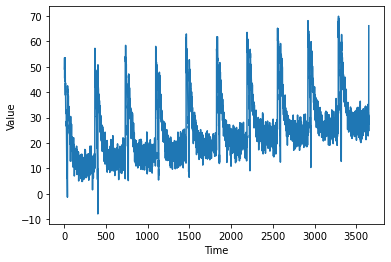

In [44]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))
    
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 128
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20,input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(loss="mae", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)


Epoch 1/100
94/94 [==============================] - 2s 14ms/step - loss: 35.0383
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 35.1618
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 35.3347
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 35.1987
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 34.8236
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 34.7520
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 35.0109
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 34.9047
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 34.2210
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 33.8038
Epoch 11/100
94/94 [==============================] - 0s 1ms/step - loss: 34.1938
Epoch 12/100
94/94 [==============================] - 0s 2ms/step - loss: 34.4968
Epoch 13/100
94/94 [====

(1e-06, 0.01, 2.5, 11.0)

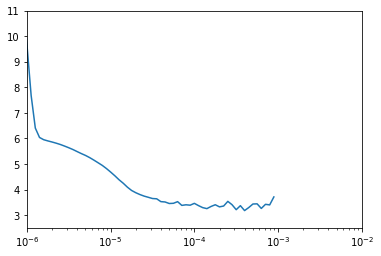

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-2, 2.5, 11])

In [53]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40,input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mae", optimizer=tf.keras.optimizers.SGD(lr=9e-4, momentum=0.9)) #loss = "mse"
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
24/24 [==============================] - 0s 8ms/step - loss: 10.8615
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 3.9644
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 3.4989
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 3.4944
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 3.5041
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 3.5169
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 3.2138
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 3.3859
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 3.3095
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 3.1789
Epoch 11/100
24/24 [==============================] - 0s 6ms/step - loss: 3.4851
Epoch 12/100
24/24 [==============================] - 0s 9ms/step - loss: 3.2709
Epoch 13/100
24/24 [================

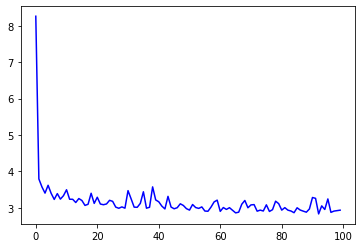

In [54]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

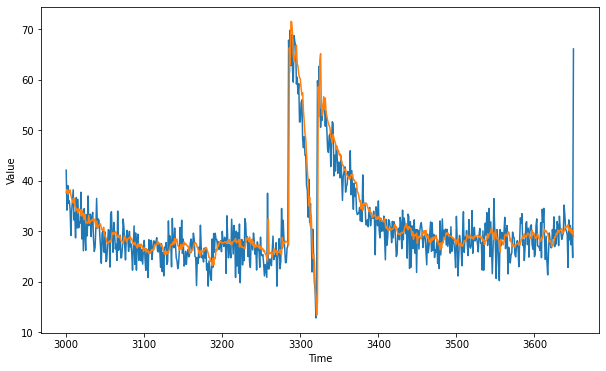

In [55]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [56]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT

2.961753

In [52]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT

3.0019283

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT

3.0217087

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT

3.040995

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT

3.061861

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

3.0682712